## Installing necessary packages

In [1]:
!pip install transformers --q

## Importing necessary packages

In [2]:
import pandas as pd
import numpy as np
from numpy import zeros

from tqdm import tqdm

import json
import torch
import pickle

from transformers import AutoModel, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, plot_confusion_matrix

from sklearn import model_selection, linear_model, naive_bayes, svm
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
import xgboost


import torch as th
from transformers import AutoModel, AutoTokenizer
import torch.utils.data as Data
from torch.optim import lr_scheduler
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

## Parameters

In [3]:
sequence_length = 512
embedding_dim = 512
batch_size = 8
epochs = 20
model_name = 'nlpaueb/legal-bert-base-uncased'

## Dataset Loader

#### Training dataset

In [4]:
train_df = pd.read_csv('../../data/model_data/train_df.csv')
print("# Size: ", train_df.shape)
train_df.head()

# Size:  (28836, 3)


,Unnamed: 0,sentence,label
0,0,"IN THE HIGH COURT OF KARNATAKA,\n ...",PREAMBLE
1,1,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,PREAMBLE
2,2,This Criminal Appeal is filed under Section 37...,PREAMBLE
3,3,\n\n This appeal coming on for hearing t...,PREAMBLE
4,4,\n Heard the learned Counsel for the app...,NONE


In [5]:
print("#Nan in sents: ", train_df.sentence.isnull().values.sum())
print("#Nan in labels: ", train_df.label.isnull().values.sum())

#Nan in sents:  0
#Nan in labels:  0


In [6]:
train_df.label.value_counts()

ANALYSIS          10623
FAC                5688
PREAMBLE           4164
PRE_RELIED         1431
NONE               1421
ARG_PETITIONER     1312
RPC                1080
RLC                 741
ARG_RESPONDENT      698
RATIO               672
STA                 481
ISSUE               367
PRE_NOT_RELIED      158
Name: label, dtype: int64

#### Validation dataset

In [7]:
dev_df = pd.read_csv('../../data/model_data/dev_df.csv')
print("# Size: ", dev_df.shape)
dev_df.head()

# Size:  (2890, 3)


,Unnamed: 0,sentence,label
0,0,PETITIONER:\nTHE COMMISSIONER OF INCOME-TAXNEW...,PREAMBLE
1,1,\n\nDATE OF JUDGMENT:\n05/05/1961\n\nBENCH:\nD...,PREAMBLE
2,2,"\nBENCH:\nDAS, S.K.\nHIDAYATULLAH, M.\nSHAH, J...",PREAMBLE
3,3,It\nentered into transactions in the nature of...,PREAMBLE
4,4,The assessee claimed deduction of these\nlosse...,PREAMBLE


In [8]:
print("#Nan in sents: ", dev_df.sentence.isnull().values.sum())
print("#Nan in labels: ", dev_df.label.isnull().values.sum())

#Nan in sents:  0
#Nan in labels:  0


In [9]:
dev_df.label.value_counts()

ANALYSIS          986
FAC               581
PREAMBLE          509
NONE              192
PRE_RELIED        142
RLC               116
RPC                92
RATIO              72
ARG_PETITIONER     70
ISSUE              51
ARG_RESPONDENT     38
STA                29
PRE_NOT_RELIED     12
Name: label, dtype: int64

#### Reading labels

In [10]:
le_encoder = LabelEncoder()
le_encoder.fit(list(train_df.label.values) + list(dev_df.label.values))

label_names = le_encoder.classes_
print(label_names)

['ANALYSIS' 'ARG_PETITIONER' 'ARG_RESPONDENT' 'FAC' 'ISSUE' 'NONE'
 'PREAMBLE' 'PRE_NOT_RELIED' 'PRE_RELIED' 'RATIO' 'RLC' 'RPC' 'STA']


In [11]:
ID_Label_Map = {}
with open('../../data/model_data/ID_Label_Map.json', 'r') as fp:
    ID_Label_Map = json.load(fp)

Label_ID_Map = {}
with open('../../data/model_data/Label_ID_Map.json', 'r') as fp:
    Label_ID_Map = json.load(fp)

print(list(Label_ID_Map.keys()))

['ANALYSIS', 'ARG_PETITIONER', 'ARG_RESPONDENT', 'FAC', 'ISSUE', 'NONE', 'PREAMBLE', 'PRE_NOT_RELIED', 'PRE_RELIED', 'RATIO', 'RLC', 'RPC', 'STA']


In [12]:
train_labels = le_encoder.transform(list(train_df.label.values))
print("# Labels: ", len(train_labels), "\tType: ", type(train_labels))

# Labels:  28836 	Type:  <class 'numpy.ndarray'>


In [13]:
dev_labels = le_encoder.transform(list(dev_df.label.values))
print("# Labels: ", len(dev_labels), "\tType: ", type(dev_labels))

# Labels:  2890 	Type:  <class 'numpy.ndarray'>


## Embeddings from the bert model

In [ ]:
class AutoencoderHead(th.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.encoder = th.nn.Sequential(
            th.nn.Linear(input_size, hidden_size),
            th.nn.ReLU(),
            th.nn.Dropout(0.1),
            th.nn.Linear(hidden_size, 580),
            th.nn.ReLU(),
            th.nn.Dropout(0.1),
        )
        self.decoder = th.nn.Sequential(
            th.nn.Linear(580, hidden_size),
            th.nn.ReLU(),
            th.nn.Dropout(0.1),
            th.nn.Linear(hidden_size, output_size),
            th.nn.ReLU(),
            th.nn.Dropout(0.1),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [39]:
class BertEmbedding(th.nn.Module):
    def __init__(self, base_model = 'roberta-base', pretrained_model='roberta-base', hidden_size = 640, embedding_size = 512):
        super(BertEmbedding, self).__init__()
        self.embedding_size = embedding_size
        self.tokenizer_1 = AutoTokenizer.from_pretrained(pretrained_model)
        self.tokenizer_2 = AutoTokenizer.from_pretrained(base_model)
        self.bert_model_1 = AutoModel.from_pretrained(pretrained_model)
        self.bert_model_2 = AutoModel.from_pretrained(base_model)
        self.feat_dim_1 = list(self.bert_model_1.modules())[-2].out_features
        self.feat_dim_2 = list(self.bert_model_2.modules())[-2].out_features
        
        self.hidden_size = 850
        self.head = AutoencoderHead(self.feat_dim_1 + self.feat_dim_2, self.hidden_size, self.embedding_size)
    
    def forward(self, input_ids = None, attention_mask = None):
        outputs = []
        
        input_ids_1 = input_ids[0]
        attention_mask_1 = attention_mask[0]
        bert_output_1 = self.bert_model_1(input_ids_1, attention_mask=attention_mask_1)[0][:, 0]
        outputs.append(bert_output_1)
        
        input_ids_2 = input_ids[1]
        attention_mask_2 = attention_mask[1]
        bert_output_2 = self.bert_model_2(input_ids_2, attention_mask=attention_mask_2)[0][:, 0]
        outputs.append(bert_output_2)
        
        # just get the [CLS] embeddings
        last_hidden_states = th.cat(outputs, dim=1)
        logits = self.classifier(last_hidden_states)
        
        return logits

In [41]:
model = BertEmbedding(pretrained_model = model_name, embedding_size=512)
model.cuda()

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.

BertEmbedding(
  (bert_model_1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

#### Preparing the data loader for bert classifier

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
def encode_input(text, tokenizer):
    tokenized_text = tokenizer(
        text,
        max_length = sequence_length,
        padding=True,
        truncation=True,
        return_tensors='pt'
    )
    return tokenized_text.input_ids, tokenized_text.attention_mask

In [44]:
input_ids, attention_mask = {'train': {0: [], 1:[]}, 'val': {0: [], 1:[]}}, {'train': {0: [], 1:[]}, 'val': {0: [], 1:[]}}

In [45]:
input_ids['train'][0], attention_mask['train'][0] = encode_input(list(train_df.sentence.values), model.tokenizer_1)
input_ids['train'][1], attention_mask['train'][1] = encode_input(list(train_df.sentence.values), model.tokenizer_2)

print(input_ids['train'][0].shape, type(input_ids['train'][0]))
print(input_ids['train'][1].shape, type(input_ids['train'][1]))
print(attention_mask['train'][0].shape, type(attention_mask['train'][0]))
print(attention_mask['train'][1].shape, type(attention_mask['train'][1]))

torch.Size([28836, 512]) <class 'torch.Tensor'>
torch.Size([28836, 512]) <class 'torch.Tensor'>
torch.Size([28836, 512]) <class 'torch.Tensor'>
torch.Size([28836, 512]) <class 'torch.Tensor'>


In [46]:
input_ids['val'][0], attention_mask['val'][0] = encode_input(list(dev_df.sentence.values), model.tokenizer_1)
input_ids['val'][1], attention_mask['val'][1] = encode_input(list(dev_df.sentence.values), model.tokenizer_2)

print(input_ids['val'][0].shape, type(input_ids['val'][0]))
print(input_ids['val'][1].shape, type(input_ids['val'][1]))
print(attention_mask['val'][0].shape, type(attention_mask['val'][0]))
print(attention_mask['val'][1].shape, type(attention_mask['val'][1]))

torch.Size([2890, 489]) <class 'torch.Tensor'>
torch.Size([2890, 512]) <class 'torch.Tensor'>
torch.Size([2890, 489]) <class 'torch.Tensor'>
torch.Size([2890, 512]) <class 'torch.Tensor'>


In [47]:
label_encode = {}
label_encode['train'] = th.LongTensor(train_labels)
label_encode['val'] = th.LongTensor(dev_labels)

print(label_encode['train'].shape, type(label_encode['train']))
print(label_encode['val'].shape, type(label_encode['val']))

torch.Size([28836]) <class 'torch.Tensor'>
torch.Size([2890]) <class 'torch.Tensor'>


In [48]:
datasets = {}
loader = {}
for split in ['train', 'val']:
    datasets[split] =  Data.TensorDataset(input_ids[split][0], attention_mask[split][0], input_ids[split][1], attention_mask[split][1], label_encode[split])
    split_sampler = None
    if split == 'train':
        split_sampler = Data.RandomSampler(datasets[split])
    else:
        split_sampler = Data.SequentialSampler(datasets[split])
    loader[split] = Data.DataLoader(datasets[split], sampler = split_sampler, batch_size = batch_size)

In [49]:
print("#train Dataset: ", len(datasets['train']))
print("#train Labels: ", len(label_encode['train']))
print("#train Loader: ", len(loader['train']))

print("#dev Dataset: ", len(datasets['val']))
print("#dev Labels: ", len(label_encode['val']))
print("#dev Loader: ", len(loader['val']))

#train Dataset:  28836
#train Labels:  28836
#train Loader:  3605
#dev Dataset:  2890
#dev Labels:  2890
#dev Loader:  362


In [50]:
unique_labels = {}
for batch in tqdm(loader['val']):
    for label in batch[4]:
        label = label.item()
        if label not in unique_labels:
            unique_labels[label] = 1
        else:
            unique_labels[label] += 1
print(unique_labels)

100%|██████████| 362/362 [00:00<00:00, 5507.41it/s]

{6: 509, 0: 986, 5: 192, 3: 581, 10: 116, 1: 70, 12: 29, 8: 142, 11: 92, 4: 51, 9: 72, 2: 38, 7: 12}


In [51]:
train_x = None
train_y = None

for batch in tqdm(loader['train']):
    (input_ids_0, attention_mask_0, input_ids_1, attention_mask_1, label_0) = [x.to(device) for x in batch]
    
    output = model(input_ids = [input_ids_0, input_ids_1], attention_mask = [attention_mask_0, attention_mask_1]).cpu().detach().numpy()
    if train_x is None:
        train_x = output
    else:
        train_x = np.append(train_x, output, axis = 0)
    
    label_0 = label_0.cpu().detach().numpy()
    if train_y is None:
        train_y = label_0
    else:
        train_y = np.append(train_y, label_0, axis = 0)

100%|██████████| 3605/3605 [17:12<00:00,  3.49it/s]


In [52]:
unique_labels = {}
for label in tqdm(train_y):
    label = label.item()
    if label not in unique_labels:
        unique_labels[label] = 1
    else:
        unique_labels[label] += 1
print(unique_labels)

100%|██████████| 28836/28836 [00:00<00:00, 1069711.67it/s]

{0: 10623, 6: 4164, 3: 5688, 1: 1312, 10: 741, 9: 672, 12: 481, 5: 1421, 11: 1080, 8: 1431, 2: 698, 7: 158, 4: 367}


In [53]:
print("#train Dataset: ", train_x.shape)
print("#train Labels: ", train_y.shape)

#train Dataset:  (28836, 512)
#train Labels:  (28836,)


In [54]:
test_x = None
test_y = None

for batch in tqdm(loader['val']):
    (input_ids_0, attention_mask_0, input_ids_1, attention_mask_1, label_0) = [x.to(device) for x in batch]
    
    output = model([input_ids_0, input_ids_1], [attention_mask_0, attention_mask_1]).cpu().detach().numpy()
    if test_x is None:
        test_x = output
    else:
        test_x = np.append(test_x, output, axis = 0)
    
    label_0 = label_0.cpu().detach().numpy()
    if test_y is None:
        test_y = label_0
    else:
        test_y = np.append(test_y, label_0, axis = 0)

100%|██████████| 362/362 [01:40<00:00,  3.59it/s]


In [55]:
unique_labels = {}
for label in tqdm(test_y):
    label = label.item()
    if label not in unique_labels:
        unique_labels[label] = 1
    else:
        unique_labels[label] += 1
print(unique_labels)

100%|██████████| 2890/2890 [00:00<00:00, 692501.06it/s]

{6: 509, 0: 986, 5: 192, 3: 581, 10: 116, 1: 70, 12: 29, 8: 142, 11: 92, 4: 51, 9: 72, 2: 38, 7: 12}


In [56]:
print("#dev Dataset: ", test_x.shape)
print("#dev Labels: ", test_y.shape)

#dev Dataset:  (2890, 512)
#dev Labels:  (2890,)


## Training

In [57]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    if is_neural_net:
        predictions = predictions.argmax(axis=-1)

    
    acc = accuracy_score(predictions, test_y)
    f1 = f1_score(predictions, test_y, average='micro')
    
    return acc, f1, classifier

### Logistic Regression

In [58]:
%%time
accuracy, f1, classifier = train_model(linear_model.LogisticRegression(solver='sag',multi_class='multinomial', max_iter=1000), train_x, train_y, test_x)
print("LR Accuracy: {}, F1 Score: {}".format(accuracy, f1))

# Save the model to output folder
filename = '../../checkpoints/lr_model.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(classifier, fp)

LR Accuracy: 0.35847750865051903, F1 Score: 0.49006823969737406
CPU times: user 20.6 s, sys: 27.1 ms, total: 20.7 s
Wall time: 20.7 s


In [59]:
with open('../../checkpoints/lr_model.pkl', 'rb') as file_1:
    classifier = pickle.load(file_1)
predictions = classifier.predict(test_x)
acc = accuracy_score(predictions, test_y)
f1 = f1_score(predictions, test_y, average='micro')
print("Accuracy: ", acc)
print("F1 Micro: ", f1)

Accuracy:  0.35847750865051903
F1 Micro:  0.35847750865051903


In [60]:
print(classification_report(test_y, predictions, target_names=list(ID_Label_Map.values())))

                precision    recall  f1-score   support

      ANALYSIS       0.36      0.95      0.52       986
ARG_PETITIONER       0.00      0.00      0.00        70
ARG_RESPONDENT       0.00      0.00      0.00        38
           FAC       0.23      0.02      0.04       581
         ISSUE       0.00      0.00      0.00        51
          NONE       0.00      0.00      0.00       192
      PREAMBLE       0.42      0.17      0.24       509
PRE_NOT_RELIED       0.00      0.00      0.00        12
    PRE_RELIED       0.00      0.00      0.00       142
         RATIO       0.00      0.00      0.00        72
           RLC       0.00      0.00      0.00       116
           RPC       0.00      0.00      0.00        92
           STA       0.00      0.00      0.00        29

      accuracy                           0.36      2890
     macro avg       0.08      0.09      0.06      2890
  weighted avg       0.24      0.36      0.23      2890



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


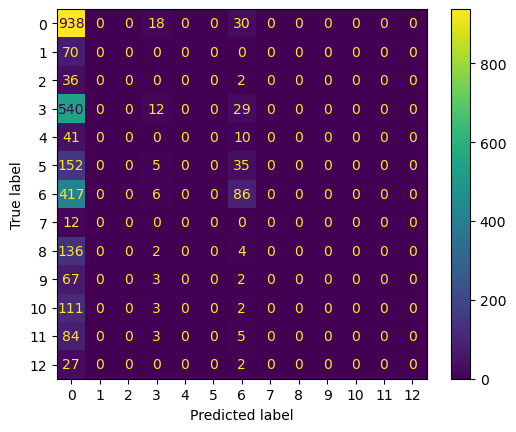

In [61]:
plot_confusion_matrix(classifier, test_x, test_y)
plt.savefig('../../model_results/lr_model.png')
plt.show()

### SVM

In [ ]:
%%time
accuracy, f1, classifier = train_model(svm.SVC(), train_x, train_y, test_x)
print("SVM Accuracy: {}, F1 Score: {}".format(accuracy, f1))

# Save the model to output folder
filename = '../../checkpoints/svm.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(classifier, fp)

In [ ]:
with open('../../checkpoints/svm.pkl', 'rb') as file_1:
    classifier = pickle.load(file_1)
predictions = classifier.predict(test_x)
acc = accuracy_score(predictions, test_y)
f1 = f1_score(predictions, test_y, average='micro')
print("Accuracy: ", acc)
print("F1 Micro: ", f1)

In [ ]:
print(classification_report(test_y, predictions, target_names=list(ID_Label_Map.values())))

In [ ]:
plot_confusion_matrix(classifier, test_x, test_y)
plt.savefig('../../model_results/svm_model.png')
plt.show()

### Boosting Model

In [ ]:
%%time
# Extereme Gradient Boosting on Count Vectors
accuracy, f1, classifier = train_model(xgboost.XGBClassifier(),  train_x, train_y, test_x)
print("Xgboost Accuracy: {}, F1 Score: {}".format(accuracy, f1))

# Save the model to output folder
filename = '../../checkpoints/boosting_model.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(classifier, fp)

In [ ]:
with open('../../checkpoints/boosting_model.pkl', 'rb') as file_1:
    classifier = pickle.load(file_1)
predictions = classifier.predict(test_x)
acc = accuracy_score(predictions, test_y)
f1 = f1_score(predictions, test_y, average='micro')
print("Accuracy: ", acc)
print("F1 Micro: ", f1)

In [ ]:
print(classification_report(test_y, predictions, target_names=list(ID_Label_Map.values())))

In [ ]:
plot_confusion_matrix(classifier, test_x, test_y)
plt.savefig('../../model_results/boosting_model.png')
plt.show()

### Random Forest

In [ ]:
%%time
accuracy, f1, classifier = train_model(ensemble.RandomForestClassifier(), train_x, train_y, test_x)
print("Random Forest Accuracy: {}, F1 Score: {}".format(accuracy, f1))

# Save the model to output folder
filename = '../../checkpoints/random_forest.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(classifier, fp)

In [ ]:
with open('../../checkpoints/random_forest.pkl', 'rb') as file_1:
    classifier = pickle.load(file_1)
predictions = classifier.predict(test_x)
acc = accuracy_score(predictions, test_y)
f1 = f1_score(predictions, test_y, average='micro')
print("Accuracy: ", acc)
print("F1 Micro: ", f1)

In [ ]:
print(classification_report(test_y, predictions, target_names=list(ID_Label_Map.values())))

In [ ]:
plot_confusion_matrix(classifier, test_x, test_y)
plt.savefig('../../model_results/random_forest_model.png')
plt.show()

### MLP

In [ ]:
%%time
accuracy, f1, classifier = train_model(MLPClassifier(random_state=1, max_iter=500), train_x, train_y, test_x)
print("MLP Accuracy: {}, F1 Score: {}".format(accuracy, f1))

# Save the model to output folder
filename = '../../checkpoints/mlp.pkl'
with open(filename, 'wb') as fp:
    pickle.dump(classifier, fp)

In [ ]:
with open('../../checkpoints/mlp.pkl', 'rb') as file_1:
    classifier = pickle.load(file_1)
predictions = classifier.predict(test_x)
acc = accuracy_score(predictions, test_y)
f1 = f1_score(predictions, test_y, average='micro')
print("Accuracy: ", acc)
print("F1 Micro: ", f1)

In [ ]:
print(classification_report(test_y, predictions, target_names=list(ID_Label_Map.values())))

In [ ]:
plot_confusion_matrix(classifier, test_x, test_y)
plt.savefig('../../model_results/mlp_model.png')
plt.show()

## Test Data Inference and submission file preparation

### Load best model

In [ ]:
with open('../../checkpoints/mlp.pkl', 'rb') as file_1:
    classifier = pickle.load(file_1)

In [ ]:
model = BertEmbedding(pretrained_model = model_name, embedding_size=512)
model.cuda()

### Read testset

In [ ]:
rr_test_data = {}
with open('../../data/model_data/SAMPLE_SUBMISSION_RR.json', 'r') as fp:
    rr_test_data = json.load(fp)
print("# Documents: ", len(rr_test_data))

In [ ]:
final_results = rr_test_data.copy()
for doc_index, entry in tqdm(enumerate(rr_test_data)):
    results = rr_test_data[doc_index]['annotations'][0]['result']
    for sent_index, sent in enumerate(results):
        
        #### Extracting the text from the test data
        sentence = sent['value']['text']
        sentence = sentence.replace(r'\s+', ' ').strip()
        
        #### Getting input ids and attention mask from the model for the given sentence
        input_ids_1, attention_mask_1 = encode_input([sentence], model.tokenizer_1)
        input_ids_2, attention_mask_2 = encode_input([sentence], model.tokenizer_2)
        output = model([input_ids_1.to(device), input_ids_2.to(device)], [attention_mask_1.to(device), attention_mask_2.to(device)]).cpu()
        
        label = None
        #### Predicting the label index from the model
        label = classifier.predict(output)

        #### Converting the label index to label text and storing
        label = ID_Label_Map.get(str(label[0]), None)
        
        if label is not None:
            final_results[doc_index]['annotations'][0]['result'][sent_index]['value']['labels'] = [label]
        else:
            print("Label is None for Doc-index: {} and Sent-index: {}".format(doc_index, sent_index))

print("# Documents: ", len(final_results))

In [ ]:
with open('../../output/RR_SUBMISSION.json', 'w') as fp:
    json.dump(final_results, fp, indent=4)